Compile model files, necessary to run NetPyNE simulation

In [ ]:
import os
if not os.path.exists('x86_64'):
    os.system('nrnivmodl mod')

from neuron import h
from netpyne import sim, specs
from scipy.io import loadmat

Load data - probabilities and weights of connections between populations

In [3]:
connLabels = ['dSN-GPi', 'iSN-GPe',
        'GPe-STN', 'STN-GPe', 'STN-GPi',
        'GPe-GPi', 'GPe-GPe', 'GPi-GPi',
        'GPi-Thl', 'Thl-iSN', 'Thl-dSN',
        'dSN-dSN', 'iSN-iSN', 'CxE-dSN', 'CxE-iSN', 'CxE-STN',
        'CxE-CxI', 'CxI-CxE', 'CxI-CxI']

def probsAndWeightsMaith(forWhom): # forWhom is 'control'/'patient'
    data_path = os.path.expanduser("~/packages/tvb-multiscale/examples/data/basal_ganglia")
    fit_data_path = os.path.join(data_path, "ANNarchyFittedModels/dataFits_2020_02_05/databestfits")
    if forWhom.lower() in ['c', 'control']:
        path = fit_data_path + '/controlleft/OutputSim_Patient08.mat'
    elif forWhom.lower() in ['p', 'patient']:
        path = fit_data_path + '/patientleft/OutputSim_Patient09.mat'
    else:
        raise Exception("Should provide arg: 'control'/'patient' (or 'c'/'p')")

    data = loadmat(path)
    probsAndWeights = data["X"][0]
    return probsAndWeights[:19], probsAndWeights[19:]

probs, weights = probsAndWeightsMaith('patient')

# print connectivity
# for i, connLabel in enumerate(connLabels):
#     print(f'\t{i}. {connLabel}: w = {weights[i]}, p = {probs[i]}')

Setup NetPyNE model - create populations

In [4]:
netParams = specs.NetParams()

def izhiCellParams(a, b, c, d, C, Ie, n0, n1, n2, uInit=-18.55, vInit=-70, vR=0, vThresh=30):
    params = {
        'mod': 'Izhi2003c', # model name (corresponds to what described in .mod file)
        'vref': 'V', # custom variable for membrane potential in Izhi2003c
        'a': a, 'b': b, 'c': c, 'd': d,
        'C': C,
        'Ie': Ie,
        'n0': n0, 'n1': n1, 'n2': n2,
        'uInit': uInit, 'vInit': vInit,
        'Vr': vR,
        'thresh': vThresh
    }
    return {
        'secs': {
            'soma': {'pointps': {'izhi': params}}
        }
    }

#                                            a          b       c       d       C   Ie      n0          n1          n2
netParams.cellParams['Str'] = izhiCellParams(0.05,      -20,    -55,    377,   50,  0,      61.65119,   2.594639,   0.022799,   vR=-80,     vThresh=40)
netParams.cellParams['GPi'] = izhiCellParams(0.005,     0.585,  -65,    4,     1,   30,     140,        5,          0.04)
netParams.cellParams['GPe'] = izhiCellParams(0.005,     0.585,  -65,    4,     1,   12,     140,        5,          0.04)
netParams.cellParams['STN'] = izhiCellParams(0.005,     0.265,  -65,    2,     1,   3,      140,        5,          0.04)
netParams.cellParams['Thl'] = izhiCellParams(0.02,      0.25,   -65,    0.05,  1,   3.5,    140,        5,          0.04)
netParams.cellParams['CxE'] = izhiCellParams(0.02,      0.2,    -72,    6,     1,   7,      140,        5,          0.04,       uInit=-14.0, vInit=-72) # I = 7 in resting, 50 when fitting
netParams.cellParams['CxI'] = izhiCellParams(0.02,      0.2,    -72,    6,     1,   0,      140,        5,          0.04,       uInit=-14.0, vInit=-72)

scale = 200

netParams.popParams['pop_dSN'] = {'cellType': 'Str', 'numCells': scale}
netParams.popParams['pop_iSN'] = {'cellType': 'Str', 'numCells': scale}
netParams.popParams['pop_GPi'] = {'cellType': 'GPi', 'numCells': scale}
netParams.popParams['pop_GPe'] = {'cellType': 'GPe', 'numCells': scale}
netParams.popParams['pop_STN'] = {'cellType': 'STN', 'numCells': scale}
netParams.popParams['pop_Thl'] = {'cellType': 'Thl', 'numCells': scale}
netParams.popParams['pop_CxE'] = {'cellType': 'CxE', 'numCells': scale * 3}
netParams.popParams['pop_CxI'] = {'cellType': 'CxI', 'numCells': int(scale * 0.75)}

Setup NetPyNE model - add connections

In [5]:
for connLabel, weight, prob in zip(connLabels, weights, probs):

    # input `connLabel` is in format 'X-Y', convert it to 'pop_X', 'pop_Y' to match population labels in `netParams.popParams`
    prePop, postPop = ['pop_' + label for label in connLabel.split('-')]

    isInhibitory = prePop not in ['pop_CxE', 'pop_STN', 'pop_Thl']

    if isInhibitory:
        weight = -weight

    params = {
        'preConds': {'pop': prePop},
        'postConds': {'pop': postPop},
        'probability': prob,
        'weight': weight
    }
    netParams.addConnParams(connLabel, params)


Configure and run the simulation

In [ ]:
cfg = specs.SimConfig()
cfg.duration = 1500
cfg.dt = 0.05
cfg.recordTraces = {'V_soma':{'sec':'soma','pointp':'izhi','var':'V'}}
cfg.allowSelfConns = True
netParams.defaultDelay = cfg.dt * 1.001 # delay can't be smaller than dt

sim.createSimulateAnalyze(netParams, cfg)

   pop_dSN : 18.665 Hz
   pop_iSN : 15.345 Hz
   pop_GPi : 35.800 Hz
   pop_GPe : 35.620 Hz
   pop_STN : 32.000 Hz
   pop_Thl : 18.825 Hz
   pop_CxE : 15.953 Hz
   pop_CxI : 31.947 Hz
Preparing spike data...
Plotting raster...
  Done; plotting time = 10.50 s


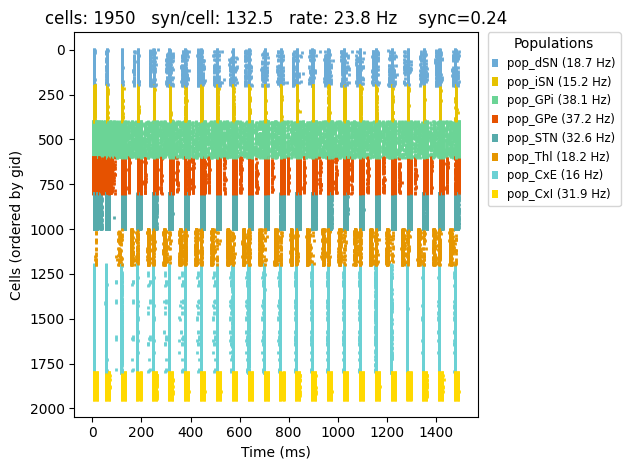

In [7]:

%matplotlib inline
# incl = [[p, 0] for p in netParams.popParams.keys()]
# sim.cfg.analysis['plotTraces'] = {'include': incl, 'showFig': True}
sim.cfg.analysis['plotRaster'] = {'showFig': True, 'popRates': 'minimal', 'orderInverse': True}
sim.analysis.popAvgRates(tranges=[500, 1500])
sim.analysis.plotData()